# Imports

In [1]:
import pandas as pd 
from pyspark import SparkContext
from pyspark import SparkConf
import pyspark
from pyspark import SparkConf, SparkContext 
sc = SparkContext.getOrCreate()
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from pyspark.sql.session import SparkSession
spark = SparkSession(sc)
from pyspark.sql.functions import *
from pyspark.sql.functions import to_date




# Load Data

In [2]:
df_traffic = spark.read.parquet("/Users/pprusty05/workspace/Data_mining/Project/data_folder/traffic_weather_data/Traffic.parquet")

In [3]:
df_traffic.printSchema()

root
 |-- EventId: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- TMC: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- StartTime: timestamp (nullable = true)
 |-- EndTime: timestamp (nullable = true)
 |-- TimeZone: string (nullable = true)
 |-- LocationLat: double (nullable = true)
 |-- LocationLng: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- AirportCode: string (nullable = true)
 |-- Number: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZipCode: integer (nullable = true)



In [4]:
df_traffic.groupBy('Type').count().show()

+--------------+--------+
|          Type|   count|
+--------------+--------+
|         Event|   44870|
|Broken-Vehicle|  518269|
|  Lane-Blocked|  400565|
|  Construction|  514021|
|    Congestion|20294005|
| Flow-Incident| 1179094|
|      Accident| 2168224|
+--------------+--------+



In [5]:
df_traffic_type=df_traffic.groupBy('Type').count().toPandas()

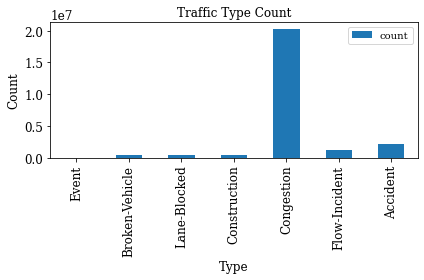

In [7]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
ax = df_traffic_type.plot(x="Type", y="count", kind="bar")
ax.set_xlabel("Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Traffic Type Count")
rcParams.update({'figure.autolayout': True})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rc('font', family='serif')
#plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/Users/pprusty05/google_drive/Data_Mining/Project/plots/Traffic_Type.pdf')
plt.show()

# Clean Data

## Missing Values

In [8]:
def find_missing_values(df):
    missing_value_dict = {}
    for column_name in df.columns:
        missing_value_count = df.where(df[column_name].isNull()).count()
        missing_value_percent = (missing_value_count / df.count()) * 100
        missing_value_dict[column_name] = {}
        missing_value_dict[column_name]['count'] =  missing_value_count
        missing_value_dict[column_name]['percent'] =  missing_value_percent

    missing_value_pd = pd.DataFrame(missing_value_dict).T
    return missing_value_pd 

In [9]:
missing_value_traffic_pd=find_missing_values(df_traffic)

In [10]:
missing_value_traffic_pd

,count,percent
EventId,0.0,0.000000
Type,0.0,0.000000
Severity,4739024.0,18.866256
TMC,0.0,0.000000
Description,4.0,0.000016
StartTime,0.0,0.000000
EndTime,0.0,0.000000
TimeZone,26621.0,0.105979
LocationLat,0.0,0.000000
LocationLng,0.0,0.000000


In [11]:
missing_value_traffic_pd['count'].sum()

19650384.0

## Drop columns

In [12]:
# Drop the description, timezone, airport cdoe
df_traffic = df_traffic.drop('Description')
df_traffic = df_traffic.drop('Number')
df_traffic = df_traffic.drop('TimeZone')

In [13]:
#Drop rows with null at Airport Code, City, State, Zipcode, street
df_traffic = df_traffic.filter(df_traffic.AirportCode.isNotNull())
df_traffic = df_traffic.filter(df_traffic.City.isNotNull())
df_traffic = df_traffic.filter(df_traffic.State.isNotNull())
df_traffic = df_traffic.filter(df_traffic.ZipCode.isNotNull())
df_traffic = df_traffic.filter(df_traffic.Street.isNotNull())



In [14]:
missing_value_traffic_pd=find_missing_values(df_traffic)

missing_value_traffic_pd


,count,percent
EventId,0.0,0.000000
Type,0.0,0.000000
Severity,4730955.0,18.868222
TMC,0.0,0.000000
StartTime,0.0,0.000000
EndTime,0.0,0.000000
LocationLat,0.0,0.000000
LocationLng,0.0,0.000000
Distance,0.0,0.000000
AirportCode,0.0,0.000000


# Add start date column

In [15]:
df_traffic.select('StartTime').show(10)
df_traffic.select('EndTime').show(10)
df_traffic = df_traffic.withColumn('StartDate', to_date(df_traffic.StartTime))


+-------------------+
|          StartTime|
+-------------------+
|2019-09-29 15:49:24|
|2019-09-29 15:38:00|
|2019-09-29 15:33:00|
|2019-09-29 15:48:00|
|2019-09-29 15:50:00|
|2019-09-29 15:59:00|
|2019-09-29 15:47:00|
|2019-09-29 14:33:00|
|2019-09-29 15:50:00|
|2019-09-29 15:52:00|
+-------------------+
only showing top 10 rows

+-------------------+
|            EndTime|
+-------------------+
|2019-09-29 17:19:04|
|2019-09-29 17:05:30|
|2019-09-29 17:43:34|
|2019-09-29 16:33:23|
|2019-09-29 16:36:57|
|2019-09-29 16:40:14|
|2019-09-29 23:26:14|
|2019-09-29 17:16:16|
|2019-09-29 16:54:57|
|2019-09-29 16:34:33|
+-------------------+
only showing top 10 rows



In [16]:
df_traffic.select('StartDate').show(10)
df_traffic = df_traffic.withColumn('EndDate', to_date(df_traffic.EndTime))

+----------+
| StartDate|
+----------+
|2019-09-29|
|2019-09-29|
|2019-09-29|
|2019-09-29|
|2019-09-29|
|2019-09-29|
|2019-09-29|
|2019-09-29|
|2019-09-29|
|2019-09-29|
+----------+
only showing top 10 rows



In [17]:
df_traffic.printSchema()

root
 |-- EventId: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- TMC: integer (nullable = true)
 |-- StartTime: timestamp (nullable = true)
 |-- EndTime: timestamp (nullable = true)
 |-- LocationLat: double (nullable = true)
 |-- LocationLng: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- AirportCode: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZipCode: integer (nullable = true)
 |-- StartDate: date (nullable = true)
 |-- EndDate: date (nullable = true)



In [ ]:
#We will take care of the severity later
#Write
df_traffic.write.parquet("/Users/pprusty05/workspace/Data_mining/Project/Traffic_cleaned.parquet")
#df_traffic = spark.read.parquet("/Users/pprusty05/workspace/Data_mining/Project/Traffic.parquet")

## Read df_traffic

In [18]:
df_traffic = spark.read.parquet("/Users/pprusty05/workspace/Data_mining/Project/data_folder/traffic_weather_data/Traffic_cleaned.parquet")

## Weather data Saving in Parquet

In [19]:
#df.withColumnRenamed('StartTime(UTC)', 'StartTime').withColumnRenamed('EndTime(UTC)', 'EndTime').write.parquet("/Users/pprusty05/workspace/Data_mining/Project/WeatherRaw.parquet")

In [20]:
df_weather = spark.read.parquet("/Users/pprusty05/workspace/Data_mining/Project/data_folder/traffic_weather_data/WeatherRaw.parquet")

In [21]:
df_weather.columns

['EventId',
 'Type',
 'Severity',
 'StartTime',
 'EndTime',
 'TimeZone',
 'LocationLat',
 'LocationLng',
 'AirportCode',
 'City',
 'County',
 'State',
 'ZipCode']

# Clean Data

## missing values

In [22]:
missing_value_weather_pd=find_missing_values(df_weather)

In [23]:
missing_value_weather_pd['count'].sum()

41866.0

## remove null rows

In [24]:
df_weather = df_weather.filter(df_weather.City.isNotNull())
df_weather = df_weather.filter(df_weather.ZipCode.isNotNull())

In [25]:
missing_value_weather_pd=find_missing_values(df_weather)
missing_value_weather_pd

,count,percent
EventId,0.0,0.0
Type,0.0,0.0
Severity,0.0,0.0
StartTime,0.0,0.0
EndTime,0.0,0.0
TimeZone,0.0,0.0
LocationLat,0.0,0.0
LocationLng,0.0,0.0
AirportCode,0.0,0.0
City,0.0,0.0


# Add start date column

In [26]:
df_weather.select('StartTime').show(10)

+-------------------+
|          StartTime|
+-------------------+
|2019-07-07 07:08:00|
|2019-07-07 20:56:00|
|2019-07-08 17:22:00|
|2019-07-08 21:56:00|
|2019-07-08 22:06:00|
|2019-07-08 22:11:00|
|2019-07-09 08:20:00|
|2019-07-09 10:09:00|
|2019-07-09 10:36:00|
|2019-07-09 10:54:00|
+-------------------+
only showing top 10 rows



In [27]:
df_weather = df_weather.withColumn('StartDate', to_date(df_weather.StartTime))
df_weather = df_weather.withColumn('EndDate', to_date(df_weather.EndTime))


In [28]:
df_weather.printSchema()

root
 |-- EventId: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- StartTime: timestamp (nullable = true)
 |-- EndTime: timestamp (nullable = true)
 |-- TimeZone: string (nullable = true)
 |-- LocationLat: double (nullable = true)
 |-- LocationLng: double (nullable = true)
 |-- AirportCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZipCode: integer (nullable = true)
 |-- StartDate: date (nullable = true)
 |-- EndDate: date (nullable = true)



In [63]:
df_weather.write.parquet("/Users/pprusty05/workspace/Data_mining/Project/Weather_cleaned.parquet")

# Read Weather

In [29]:
df_weather = spark.read.parquet("/Users/pprusty05/workspace/Data_mining/Project/data_folder/traffic_weather_data/Weather_cleaned.parquet")

In [30]:
df_weather.columns

['EventId',
 'Type',
 'Severity',
 'StartTime',
 'EndTime',
 'TimeZone',
 'LocationLat',
 'LocationLng',
 'AirportCode',
 'City',
 'County',
 'State',
 'ZipCode',
 'StartDate',
 'EndDate']

In [31]:
df_weather_type=df_weather.groupBy('Type').count().toPandas()

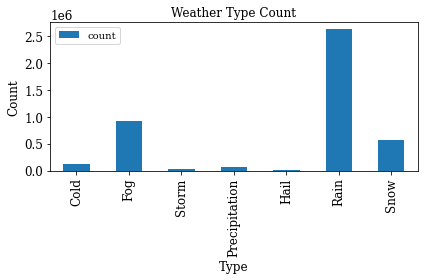

In [32]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
ax = df_weather_type.plot(x="Type", y="count", kind="bar")
ax.set_xlabel("Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Weather Type Count")
rcParams.update({'figure.autolayout': True})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rc('font', family='serif')
plt.tight_layout()
plt.savefig('/Users/pprusty05/google_drive/Data_Mining/Project/plots/Weather_Type.pdf')
plt.show()

# Merge Two dataset

## rename traffic data columns

In [33]:
column_name = df_traffic.columns
for col in column_name:
    df_traffic = df_traffic.withColumnRenamed(col, 'TR_' + col)

In [34]:
df_traffic.printSchema()

root
 |-- TR_EventId: string (nullable = true)
 |-- TR_Type: string (nullable = true)
 |-- TR_Severity: string (nullable = true)
 |-- TR_TMC: integer (nullable = true)
 |-- TR_StartTime: timestamp (nullable = true)
 |-- TR_EndTime: timestamp (nullable = true)
 |-- TR_LocationLat: double (nullable = true)
 |-- TR_LocationLng: double (nullable = true)
 |-- TR_Distance: double (nullable = true)
 |-- TR_AirportCode: string (nullable = true)
 |-- TR_Street: string (nullable = true)
 |-- TR_Side: string (nullable = true)
 |-- TR_City: string (nullable = true)
 |-- TR_County: string (nullable = true)
 |-- TR_State: string (nullable = true)
 |-- TR_ZipCode: integer (nullable = true)
 |-- TR_StartDate: date (nullable = true)
 |-- TR_EndDate: date (nullable = true)



## Rename weather data columns

In [35]:
column_name = df_weather.columns
for col in column_name:
    df_weather = df_weather.withColumnRenamed(col, 'WR_' + col)

In [36]:
df_weather.printSchema()

root
 |-- WR_EventId: string (nullable = true)
 |-- WR_Type: string (nullable = true)
 |-- WR_Severity: string (nullable = true)
 |-- WR_StartTime: timestamp (nullable = true)
 |-- WR_EndTime: timestamp (nullable = true)
 |-- WR_TimeZone: string (nullable = true)
 |-- WR_LocationLat: double (nullable = true)
 |-- WR_LocationLng: double (nullable = true)
 |-- WR_AirportCode: string (nullable = true)
 |-- WR_City: string (nullable = true)
 |-- WR_County: string (nullable = true)
 |-- WR_State: string (nullable = true)
 |-- WR_ZipCode: integer (nullable = true)
 |-- WR_StartDate: date (nullable = true)
 |-- WR_EndDate: date (nullable = true)



## Inner join based on start date and zipcode

In [37]:
inner_join = df_traffic.join(df_weather, (df_traffic.TR_ZipCode == df_weather.WR_ZipCode) &
                             (df_traffic.TR_StartDate == df_weather.WR_StartDate))

In [38]:
inner_join.printSchema()

root
 |-- TR_EventId: string (nullable = true)
 |-- TR_Type: string (nullable = true)
 |-- TR_Severity: string (nullable = true)
 |-- TR_TMC: integer (nullable = true)
 |-- TR_StartTime: timestamp (nullable = true)
 |-- TR_EndTime: timestamp (nullable = true)
 |-- TR_LocationLat: double (nullable = true)
 |-- TR_LocationLng: double (nullable = true)
 |-- TR_Distance: double (nullable = true)
 |-- TR_AirportCode: string (nullable = true)
 |-- TR_Street: string (nullable = true)
 |-- TR_Side: string (nullable = true)
 |-- TR_City: string (nullable = true)
 |-- TR_County: string (nullable = true)
 |-- TR_State: string (nullable = true)
 |-- TR_ZipCode: integer (nullable = true)
 |-- TR_StartDate: date (nullable = true)
 |-- TR_EndDate: date (nullable = true)
 |-- WR_EventId: string (nullable = true)
 |-- WR_Type: string (nullable = true)
 |-- WR_Severity: string (nullable = true)
 |-- WR_StartTime: timestamp (nullable = true)
 |-- WR_EndTime: timestamp (nullable = true)
 |-- WR_TimeZone: 

In [39]:
missing_value_weather_pd=find_missing_values(inner_join)
missing_value_weather_pd

,count,percent
TR_EventId,0.0,0.000000
TR_Type,0.0,0.000000
TR_Severity,712913.0,12.853749
TR_TMC,0.0,0.000000
TR_StartTime,0.0,0.000000
TR_EndTime,0.0,0.000000
TR_LocationLat,0.0,0.000000
TR_LocationLng,0.0,0.000000
TR_Distance,0.0,0.000000
TR_AirportCode,0.0,0.000000


In [20]:
inner_join.write.parquet("/Users/pprusty05/workspace/Data_mining/Project/TrafficWeatherMerged.parquet")

In [40]:
inner_join.count()

5546343

In [41]:
df_weather.count()

4328353

In [42]:
df_traffic.count()

25073666